# COSC522 Fall 2022 Final Project - 4-LDR

## Team Members
Dan Scott <br>
Adam McDaniel<br>
Logan Wrinkle<br>

This notebook sets up the labels and models for the 4-LDR configuration.

In [1]:
import numpy as np
import pandas as pd
import os
import re
from glob import glob
import time
from datetime import datetime
import datetime
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import ndimage
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score

## Gather Data from raw LDR values

The data for the 4-LDR models was captured on the Raspberry Pi and transfered to the raw data folder. A file of 100+ events was produced for each direction and saved with the direction (D0, D1,...) in the file name to make identification by programatic means possible.

In [2]:
root = os.getcwd()
data = '../data/raw_data_do_not_edit/'

#list of all CSV files in directory
list_of_all_files = glob(os.path.join(data, 'output_4*.txt'))
list_of_all_files.sort()
from pprint import pprint  
pprint(list(enumerate(list_of_all_files, start=0)))

[(0, '../data/raw_data_do_not_edit\\output_4_D0.txt'),
 (1, '../data/raw_data_do_not_edit\\output_4_D1.txt'),
 (2, '../data/raw_data_do_not_edit\\output_4_D2.txt'),
 (3, '../data/raw_data_do_not_edit\\output_4_D3.txt'),
 (4, '../data/raw_data_do_not_edit\\output_4_D4.txt'),
 (5, '../data/raw_data_do_not_edit\\output_4_D5.txt'),
 (6, '../data/raw_data_do_not_edit\\output_4_D6.txt'),
 (7, '../data/raw_data_do_not_edit\\output_4_D7.txt')]


In [3]:
#General purpose read CSV with NO data types infered, this is needed because the time stamp does not auto convert using pandas
def getCSVData(fname):
    List_data=[]
    with open(fname) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            List_data.append(row)
            line_count+=1  
    return List_data

## Global parameters for identifing the events based on the average percent change over N rows

In [4]:
N = 18       # Rolling average over N rows
rLen = 20    # use this many rows of data to predict 
PCT = 0.01   # flag if any change in percentage from previous row changes by PCT

## Labeling Data
### Add columns that will help identify an 'Event'

In [5]:
def fixDF(datafrm, direction):
    datafrm['Class']= 'D99'

    LDR_Data_type = 'int64'

    # datafrm['TimeNS'] = datafrm['TimeNS'].apply(lambda x: datetime.datetime.fromtimestamp(float(x)).strftime('%c'))
    datafrm['LDR0'] = datafrm['LDR0'].astype(LDR_Data_type)
    datafrm['LDR1'] = datafrm['LDR1'].astype(LDR_Data_type)
    datafrm['LDR2'] = datafrm['LDR2'].astype(LDR_Data_type)
    datafrm['LDR3'] = datafrm['LDR3'].astype(LDR_Data_type)
   
    #Calculate the rolling window average for N rows
    datafrm['AVG_LDR0'] = datafrm['LDR0'].rolling(N).mean()
    datafrm['AVG_LDR1'] = datafrm['LDR1'].rolling(N).mean()
    datafrm['AVG_LDR2'] = datafrm['LDR2'].rolling(N).mean()
    datafrm['AVG_LDR3'] = datafrm['LDR3'].rolling(N).mean()

    #calculate the PCT change from the previous row of the movign average
    datafrm['CHG_LDR0'] = datafrm['AVG_LDR0'].pct_change()      # (current value - previous value ) / current value
    datafrm['CHG_LDR1'] = datafrm['AVG_LDR1'].pct_change()
    datafrm['CHG_LDR2'] = datafrm['AVG_LDR2'].pct_change()
    datafrm['CHG_LDR3'] = datafrm['AVG_LDR3'].pct_change()

    #if the PCT change of the rolling average is >= %PCT% (0.01), then create a flag 
    datafrm['BIN_LDR0'] = datafrm['CHG_LDR0'].apply(lambda x: 1 if x >= PCT else 0)
    datafrm['BIN_LDR1'] = datafrm['CHG_LDR1'].apply(lambda x: 1 if x >= PCT else 0)
    datafrm['BIN_LDR2'] = datafrm['CHG_LDR2'].apply(lambda x: 1 if x >= PCT else 0)
    datafrm['BIN_LDR3'] = datafrm['CHG_LDR3'].apply(lambda x: 1 if x >= PCT else 0)
    
    #accumulate the flags
    datafrm['BIN_SUM'] = datafrm['BIN_LDR0'] + datafrm['BIN_LDR1'] + datafrm['BIN_LDR2']  + datafrm['BIN_LDR3'] 
    
    datafrm['Class'] = datafrm['BIN_SUM'].apply(lambda x: direction if x>=1 else 'D99')
    return datafrm


### Process all the labeled files and create the 

In [6]:
def getFileName(f):
    """get the file name without extension """
    r = f.split("\\",1)[-1]
    return r.split(".",1)[0]


#look up the class ID using the file name; it requires the file naming convention like output_4_D0....txt
def getClass(f):
    """Return the class label based on the the first occurance of the regular expression find D[0-9]"""
    r = re.search(r'D[0-9]', f)
    return r[0]

i=0
for x in list_of_all_files:
    i+=1
    direction = getClass(getFileName(x))
    df = pd.DataFrame(getCSVData(x), columns=['TimeNS', 'LDR0', 'LDR1', 'LDR2', 'LDR3'])
    df = fixDF(df,direction)
    saveName = f'..\\data\\df_4_{direction}_{i}.csv'
    df.to_csv(saveName, index=False)
    

### Save Labeled Data

In [7]:
path = '../data/'
all_files = glob(os.path.join(path, "df_4*.csv"))

df_4 = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

In [8]:
df_4.dropna(inplace=True)
df_4.reset_index(inplace=True,drop=True)

In [9]:
df_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199452 entries, 0 to 199451
Data columns (total 19 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   TimeNS    199452 non-null  float64
 1   LDR0      199452 non-null  int64  
 2   LDR1      199452 non-null  int64  
 3   LDR2      199452 non-null  int64  
 4   LDR3      199452 non-null  int64  
 5   Class     199452 non-null  object 
 6   AVG_LDR0  199452 non-null  float64
 7   AVG_LDR1  199452 non-null  float64
 8   AVG_LDR2  199452 non-null  float64
 9   AVG_LDR3  199452 non-null  float64
 10  CHG_LDR0  199452 non-null  float64
 11  CHG_LDR1  199452 non-null  float64
 12  CHG_LDR2  199452 non-null  float64
 13  CHG_LDR3  199452 non-null  float64
 14  BIN_LDR0  199452 non-null  int64  
 15  BIN_LDR1  199452 non-null  int64  
 16  BIN_LDR2  199452 non-null  int64  
 17  BIN_LDR3  199452 non-null  int64  
 18  BIN_SUM   199452 non-null  int64  
dtypes: float64(9), int64(9), object(1)
memory us

In [10]:
df_4.head()

,TimeNS,LDR0,LDR1,LDR2,LDR3,Class,AVG_LDR0,AVG_LDR1,AVG_LDR2,AVG_LDR3,CHG_LDR0,CHG_LDR1,CHG_LDR2,CHG_LDR3,BIN_LDR0,BIN_LDR1,BIN_LDR2,BIN_LDR3,BIN_SUM
0,1.668909e+09,25344,19200,27648,21952,D99,25347.555556,19200.0,27648.0,21980.444444,0.00000,0.0,0.0,0.000000,0,0,0,0,0
1,1.668909e+09,25408,19200,27648,21952,D99,25351.111111,19200.0,27648.0,21980.444444,0.00014,0.0,0.0,0.000000,0,0,0,0,0
2,1.668909e+09,25344,19200,27648,21952,D99,25351.111111,19200.0,27648.0,21980.444444,0.00000,0.0,0.0,0.000000,0,0,0,0,0
3,1.668909e+09,25408,19200,27648,22016,D99,25354.666667,19200.0,27648.0,21984.000000,0.00014,0.0,0.0,0.000162,0,0,0,0,0
4,1.668909e+09,25344,19200,27648,22016,D99,25351.111111,19200.0,27648.0,21987.555556,-0.00014,0.0,0.0,0.000162,0,0,0,0,0


### Now calculate the center of mass for N lines/event 

The caclculation starts at the first change in average for any columns (PCT >.01)

only take the center of mass columns for rLen rows 

In [11]:
# iterating over rows using iterrows() function
indxs=[]
j=0
cls='D99'
for index, row in df_4.iterrows():
    if row['BIN_SUM'] >= 1:
        cls=row['Class']    #pick up the class from the first row
        if (index != (j)):
            if (index != (j+1)):
                indxs.append([index,cls])
                # print (index, cls)
            cls=row['Class']
            j=index
                
new_data=[]
for a,b in indxs:
    Cw = ndimage.center_of_mass(df_4.iloc[a:a+rLen,10].values)
    Cx = ndimage.center_of_mass(df_4.iloc[a:a+rLen,11].values)
    Cy = ndimage.center_of_mass(df_4.iloc[a:a+rLen,12].values)
    Cz = ndimage.center_of_mass(df_4.iloc[a:a+rLen,13].values)
    new_data.append([Cw, Cx, Cy, Cz, b])
    
new_df_1 = pd.DataFrame(new_data,columns=['Cw','Cx', 'Cy', 'Cz', 'Class'])
new_df_1.to_csv('..\\data\\CM_100_4.csv',index=False)

In [12]:
df_4.head()

,TimeNS,LDR0,LDR1,LDR2,LDR3,Class,AVG_LDR0,AVG_LDR1,AVG_LDR2,AVG_LDR3,CHG_LDR0,CHG_LDR1,CHG_LDR2,CHG_LDR3,BIN_LDR0,BIN_LDR1,BIN_LDR2,BIN_LDR3,BIN_SUM
0,1.668909e+09,25344,19200,27648,21952,D99,25347.555556,19200.0,27648.0,21980.444444,0.00000,0.0,0.0,0.000000,0,0,0,0,0
1,1.668909e+09,25408,19200,27648,21952,D99,25351.111111,19200.0,27648.0,21980.444444,0.00014,0.0,0.0,0.000000,0,0,0,0,0
2,1.668909e+09,25344,19200,27648,21952,D99,25351.111111,19200.0,27648.0,21980.444444,0.00000,0.0,0.0,0.000000,0,0,0,0,0
3,1.668909e+09,25408,19200,27648,22016,D99,25354.666667,19200.0,27648.0,21984.000000,0.00014,0.0,0.0,0.000162,0,0,0,0,0
4,1.668909e+09,25344,19200,27648,22016,D99,25351.111111,19200.0,27648.0,21987.555556,-0.00014,0.0,0.0,0.000162,0,0,0,0,0


In [13]:
new_df_1.head(10)

,Cw,Cx,Cy,Cz,Class
0,"(12.036852487959314,)","(8.89621214456614,)","(13.038332849497609,)","(14.3738343844793,)",D0
1,"(12.729731005688208,)","(9.340290889048868,)","(13.68350508212238,)","(15.283667851366056,)",D0
2,"(11.111345931917272,)","(7.794160936650204,)","(12.378663315841857,)","(13.630991080568627,)",D0
3,"(11.001469686611435,)","(7.013055885584935,)","(11.643203702057129,)","(13.48213293900231,)",D0
4,"(8.844545622048539,)","(4.33298977974726,)","(8.665997323844104,)","(11.549633375441285,)",D0
5,"(12.598263787496697,)","(9.208143708231246,)","(13.102087120871678,)","(14.792056099168304,)",D0
6,"(11.396471001128027,)","(8.443871172079755,)","(12.304175888262687,)","(13.792984877250511,)",D0
7,"(12.5666098134125,)","(8.52213533062417,)","(12.507473554716743,)","(14.390815798364208,)",D0
8,"(11.390238767930066,)","(7.420461602081773,)","(11.363435799957951,)","(13.264891900567104,)",D0
9,"(9.812723681669404,)","(5.2113951615692375,)","(9.270212907595432,)","(12.336168431755617,)",D0


In [14]:
new_df_1['Class'].value_counts()

D1    171
D4    130
D3    126
D2    118
D6    118
D5    113
D7    112
D0    105
Name: Class, dtype: int64

In [15]:
df_4 = pd.concat([new_df_1['Cw'].apply(pd.Series),
                  new_df_1['Cx'].apply(pd.Series),
                  new_df_1['Cy'].apply(pd.Series),
                  new_df_1['Cz'].apply(pd.Series),
                  new_df_1['Class']], axis = 1)


In [16]:
df_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 993 entries, 0 to 992
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       993 non-null    float64
 1   0       993 non-null    float64
 2   0       993 non-null    float64
 3   0       993 non-null    float64
 4   Class   993 non-null    object 
dtypes: float64(4), object(1)
memory usage: 38.9+ KB


## Split data into Train/Test and Labeled data sets

In [17]:
from sklearn.preprocessing import LabelEncoder
X3 = df_4.iloc[:,:-1]
X3.columns=['Cw', 'Cx', 'Cy', 'Cz']
le = LabelEncoder()
y3 = le.fit_transform(df_4['Class'])

In [18]:
X3.head()

,Cw,Cx,Cy,Cz
0,12.036852,8.896212,13.038333,14.373834
1,12.729731,9.340291,13.683505,15.283668
2,11.111346,7.794161,12.378663,13.630991
3,11.001470,7.013056,11.643204,13.482133
4,8.844546,4.332990,8.665997,11.549633


In [19]:
#Split data into test and training data sets
X_train, X_test, y_train, y_test = train_test_split(X3.values, y3, test_size=0.30, random_state=45,stratify=np.array(y3)) 


## Random Forest Classifier

In [20]:
#training the model
from sklearn.datasets import make_classification


model = RandomForestClassifier(random_state=42,n_estimators=100,criterion='gini',class_weight='balanced')

model.fit(X_train, y_train)

cv_scores = cross_val_score(model, X_train, y_train, cv=10)
print('Average Cross Validation Score from Training:', cv_scores.mean(), sep='\n', end='\n\n\n')

#testing the model
ypred = model.predict(X_test)
cm = confusion_matrix(y_test, ypred)
cr = classification_report(y_test, ypred)

print('Confusion Matrix:', cm, sep='\n', end='\n\n\n')
print('Test Statistics:', cr, sep='\n', end='\n\n\n')

#This is what we will be grading (>95 expected)
print('Testing Accuracy:', accuracy_score(y_test, ypred))

Average Cross Validation Score from Training:
0.9712215320910975


Confusion Matrix:
[[31  0  0  1  0  0  0  0]
 [ 1 49  1  0  0  0  0  0]
 [ 0  1 34  0  0  0  0  0]
 [ 0  0  0 36  2  0  0  0]
 [ 0  0  0  0 39  0  0  0]
 [ 1  0  0  0  0 32  1  0]
 [ 0  0  0  0  0  1 34  0]
 [ 0  0  0  0  0  0  2 32]]


Test Statistics:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95        32
           1       0.98      0.96      0.97        51
           2       0.97      0.97      0.97        35
           3       0.97      0.95      0.96        38
           4       0.95      1.00      0.97        39
           5       0.97      0.94      0.96        34
           6       0.92      0.97      0.94        35
           7       1.00      0.94      0.97        34

    accuracy                           0.96       298
   macro avg       0.96      0.96      0.96       298
weighted avg       0.96      0.96      0.96       298



Testing Accuracy: 0.963087

In [21]:
#save this awesome RF model as full_file_RF.mod
import pickle
filename = '4LDR_RF.sav'
pickle.dump(model, open(filename, 'wb'))


## HistGradientBoostingClassifier


In [22]:
from sklearn.ensemble import HistGradientBoostingClassifier

clf = HistGradientBoostingClassifier() 
clf.fit(X_train, y_train)
cv_scores = cross_val_score(clf, X_train, y_train, cv=10)
print('Average Cross Validation Score from Training:', cv_scores.mean(), sep='\n', end='\n\n\n')


#testing the model
ypred = clf.predict(X_test)
cm = confusion_matrix(y_test, ypred)
cr = classification_report(y_test, ypred)

print('Confusion Matrix:', cm, sep='\n', end='\n\n\n')
print('Test Statistics:', cr, sep='\n', end='\n\n\n')

#This is what we will be grading (>95 expected)
print('Testing Accuracy:', accuracy_score(y_test, ypred))

Average Cross Validation Score from Training:
0.9697929606625258


Confusion Matrix:
[[31  1  0  0  0  0  0  0]
 [ 1 47  3  0  0  0  0  0]
 [ 0  0 34  1  0  0  0  0]
 [ 0  0  0 36  2  0  0  0]
 [ 0  0  0  0 39  0  0  0]
 [ 1  0  0  0  1 32  0  0]
 [ 0  0  0  0  0  1 34  0]
 [ 0  0  0  0  0  0  2 32]]


Test Statistics:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95        32
           1       0.98      0.92      0.95        51
           2       0.92      0.97      0.94        35
           3       0.97      0.95      0.96        38
           4       0.93      1.00      0.96        39
           5       0.97      0.94      0.96        34
           6       0.94      0.97      0.96        35
           7       1.00      0.94      0.97        34

    accuracy                           0.96       298
   macro avg       0.96      0.96      0.96       298
weighted avg       0.96      0.96      0.96       298



Testing Accuracy: 0.956375

In [23]:
import pickle
filename = '4LDR_XGB.sav'
pickle.dump(clf, open(filename, 'wb'))

### Test one data point

In [24]:
C2 = (10.87041,)
Cx = (10.98897041,)
Cy = (8.06188478,)
Cz = (6.78354568,)

pred_data = list([[ Cw[0], Cx[0], Cy[0], Cz[0] ]])
print(pred_data)

clf.predict(pred_data)

[[6.796343542122595, 10.98897041, 8.06188478, 6.78354568]]


array([5])

## Support Vector Classifier

In [25]:
clfs = SVC(kernel='linear',probability=True) #note the default kernel here is 'rbf' - radial basis function

clfs.fit(X_train, y_train)
cv_scores = cross_val_score(clfs, X_train, y_train, cv=10)
print('Average Cross Validation Score from Training:', cv_scores.mean(), sep='\n', end='\n\n\n')


#testing the model
ypred = clfs.predict(X_test)
cm = confusion_matrix(y_test, ypred)
cr = classification_report(y_test, ypred)

print('Confusion Matrix:', cm, sep='\n', end='\n\n\n')
print('Test Statistics:', cr, sep='\n', end='\n\n\n')

#This is what we will be grading (>95 expected)
print('Testing Accuracy:', accuracy_score(y_test, ypred))

Average Cross Validation Score from Training:
0.9913871635610766


Confusion Matrix:
[[31  1  0  0  0  0  0  0]
 [ 0 51  0  0  0  0  0  0]
 [ 0  0 35  0  0  0  0  0]
 [ 0  0  0 38  0  0  0  0]
 [ 0  0  0  0 39  0  0  0]
 [ 1  0  0  0  0 33  0  0]
 [ 0  0  0  0  0  0 35  0]
 [ 0  0  0  0  0  0  0 34]]


Test Statistics:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        32
           1       0.98      1.00      0.99        51
           2       1.00      1.00      1.00        35
           3       1.00      1.00      1.00        38
           4       1.00      1.00      1.00        39
           5       1.00      0.97      0.99        34
           6       1.00      1.00      1.00        35
           7       1.00      1.00      1.00        34

    accuracy                           0.99       298
   macro avg       0.99      0.99      0.99       298
weighted avg       0.99      0.99      0.99       298



Testing Accuracy: 0.993288

In [26]:
print(clfs.n_support_)

[ 6  7  9  5  5  7 10  5]


In [27]:
clfs.support_vectors_

array([[ 6.70994087,  2.75627276,  6.51314755,  9.00361633],
       [ 8.30380977,  4.06628203,  7.27539745, 10.71111886],
       [11.396471  ,  8.44387117, 12.30417589, 13.79298488],
       [11.78339884,  8.65697389, 13.85228841, 14.59496159],
       [ 6.09607521,  2.58476193,  7.25397614,  9.67817599],
       [12.56660981,  8.52213533, 12.50747355, 14.3908158 ],
       [12.89072104,  9.59940906,  8.71106473, 12.1569437 ],
       [11.92041763,  6.66675723,  6.24754276, 11.07365971],
       [11.06983911,  7.40523295,  3.935302  ,  9.5307478 ],
       [11.99774586,  8.28042472,  7.05491418, 11.92758482],
       [14.32821875,  9.81354375,  7.27358686, 11.96129149],
       [13.8733051 , 10.97273694,  8.42651377, 12.30329974],
       [14.14616211,  9.98226752,  8.72842832, 13.56144988],
       [15.95001034, 15.10330755,  8.78340665, 11.95264516],
       [13.9254115 , 12.2707584 ,  8.08943246, 11.64812039],
       [14.26808596, 12.67517442,  8.43322346, 11.77622674],
       [12.22286792,  9.

In [28]:
clfs.support_

array([ 68,  76, 104, 127, 166, 692, 121, 132, 215, 300, 427, 527, 558,
        58,  86, 183, 262, 338, 425, 450, 640, 662, 162, 197, 248, 473,
       634,  78, 112, 330, 339, 347, 113, 147, 178, 209, 233, 397, 625,
        35,  37,  42,  75, 100, 137, 319, 454, 460, 664, 143, 318, 503,
       536, 556])

In [29]:
import pickle
filename = '4LDR_SVC.sav'
pickle.dump(clfs, open(filename, 'wb'))

# Grid Search for best parameters

In [30]:
#Plot all the parameters from the grid search 
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

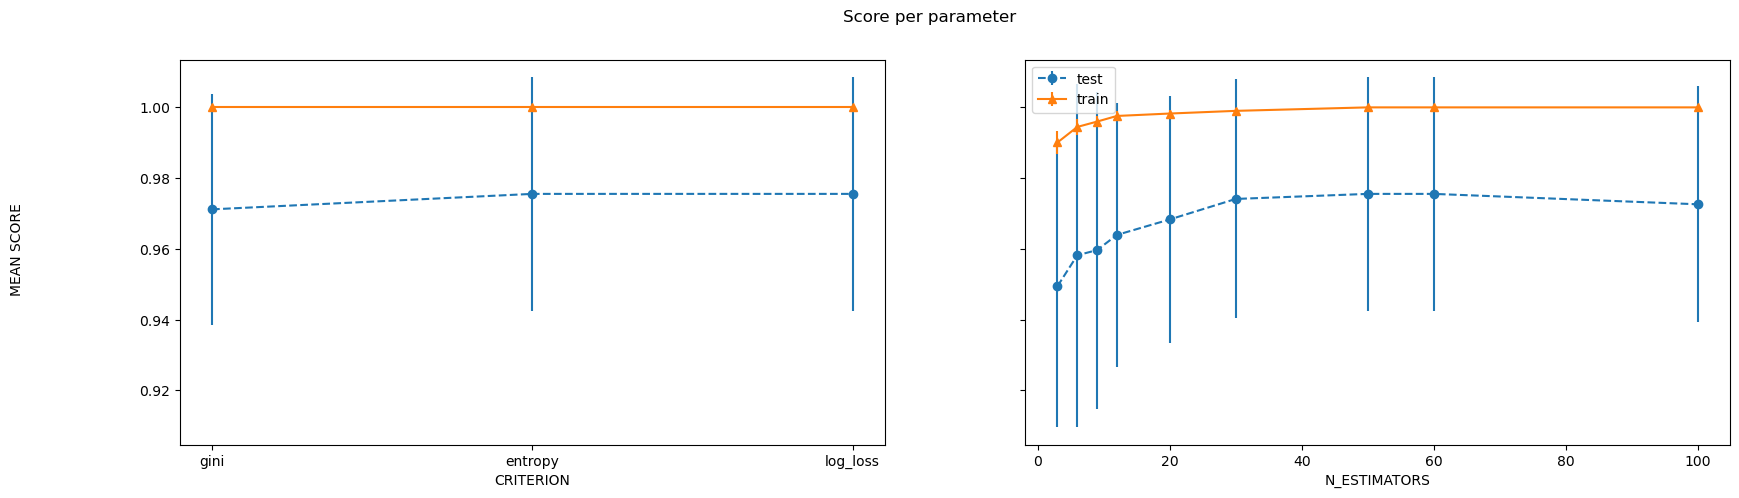

In [31]:
from sklearn.model_selection import GridSearchCV
parameters = { 'n_estimators':[3, 6, 9, 12, 20, 30, 50, 60, 100], 
               'criterion':('gini','entropy','log_loss'),
             }

RFst = RandomForestClassifier(class_weight='balanced', random_state=52)
clf = GridSearchCV(RFst, parameters, cv=20,  return_train_score=True)

clf.fit(X_train, y_train)

plot_search_results(clf)

In [32]:
print(f' Number of rows to average: {N}, number of rows to train/test: {rLen}, {clf.best_params_}, Score: {clf.best_score_}')

 Number of rows to average: 18, number of rows to train/test: 20, {'criterion': 'entropy', 'n_estimators': 50}, Score: 0.9755462184873949


In [33]:
#with all the samples 4LDR:
# Number of rows to average: 18, number of rows to train/test: 20, {'criterion':    'gini', 'n_estimators': 60}, Score: 0.9938898971566849
# Number of rows to average: 18, number of rows to train/test: 20, {'criterion': 'entropy', 'n_estimators': 100}, Score: 0.9887174108480672
# Number of rows to average: 18, number of rows to train/test: 20, {'criterion': 'entropy', 'n_estimators': 50}, Score: 0.9755462184873949


## Random Forest

In [34]:
#training the model
from sklearn.datasets import make_classification

#Split data into test and training data sets
X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size=0.40, random_state=45,stratify=np.array(y3)) 


model = RandomForestClassifier(random_state=42,n_estimators=60,criterion='entropy',class_weight='balanced')

model.fit(X_train, y_train)

cv_scores = cross_val_score(model, X_train, y_train, cv=10)
print('Average Cross Validation Score from Training:', cv_scores.mean(), sep='\n', end='\n\n\n')

#testing the model
ypred = model.predict(X_test)
cm = confusion_matrix(y_test, ypred)
cr = classification_report(y_test, ypred)

print('Confusion Matrix:', cm, sep='\n', end='\n\n\n')
print('Test Statistics:', cr, sep='\n', end='\n\n\n')

#This is what we will be grading (>95 expected)
print('Testing Accuracy:', accuracy_score(y_test, ypred))

Average Cross Validation Score from Training:
0.9664689265536722


Confusion Matrix:
[[41  0  1  0  0  0  0  0]
 [ 3 66  0  0  0  0  0  0]
 [ 0  0 46  1  0  0  0  0]
 [ 0  0  0 48  3  0  0  0]
 [ 0  0  0  0 52  0  0  0]
 [ 1  0  0  0  0 41  3  0]
 [ 0  0  0  0  0  0 47  0]
 [ 0  0  0  0  0  0  2 43]]


Test Statistics:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94        42
           1       1.00      0.96      0.98        69
           2       0.98      0.98      0.98        47
           3       0.98      0.94      0.96        51
           4       0.95      1.00      0.97        52
           5       1.00      0.91      0.95        45
           6       0.90      1.00      0.95        47
           7       1.00      0.96      0.98        45

    accuracy                           0.96       398
   macro avg       0.96      0.96      0.96       398
weighted avg       0.97      0.96      0.96       398



Testing Accuracy: 0.964824

In [35]:
model.n_features_in_
# model.n_features_

4